In [227]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os


Preprocessing

In [243]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, ADASYN
import os

# Adjust file path check
data_path = 'Spectro_Potassium.xlsx'
if not os.path.exists(data_path):
    raise FileNotFoundError(
        f"The file at {data_path} does not exist. Please verify the file location and name, and try again."
    )

# Load the dataset
try:
    df = pd.read_excel(data_path)
    print("Dataset loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading the dataset: {e}")

# Extract spectral data (columns with wavelengths)
spectral_columns = [col for col in df.columns if str(col).isdigit()]
if not spectral_columns:
    raise ValueError("No spectral columns found in the dataset. Ensure numerical columns represent wavelengths.")

spectral_data = df[spectral_columns].to_numpy()

# Step 1: Noise Reduction (Savitzky-Golay Filter)
try:
    smoothed_spectral_data = savgol_filter(spectral_data, window_length=11, polyorder=3, axis=1)
    print("Noise reduction completed.")
except Exception as e:
    raise RuntimeError(f"Error during noise reduction: {e}")

# Step 2: Baseline Correction (Continuum Removal)
def detrend(data):
    x = np.arange(data.shape[1])
    baseline_corrected = []
    for row in data:
        p = np.polyfit(x, row, deg=2)
        baseline = np.polyval(p, x)
        baseline_corrected.append(row - baseline)
    return np.array(baseline_corrected)

try:
    corrected_spectral_data = detrend(smoothed_spectral_data)
    print("Baseline correction completed.")
except Exception as e:
    raise RuntimeError(f"Error during baseline correction: {e}")

# Step 3: Normalization (Scaling to [0, 1])
scaler = MinMaxScaler()
try:
    normalized_spectral_data = scaler.fit_transform(corrected_spectral_data)
    print("Normalization completed.")
except Exception as e:
    raise RuntimeError(f"Error during normalization: {e}")

# Replace original spectral columns with preprocessed data
df[spectral_columns] = normalized_spectral_data

# Step 4: Feature Selection using PCA
try:
    pca = PCA(n_components=0.95)
    pca_features = pca.fit_transform(normalized_spectral_data)
    pca_columns = [f"PC{i+1}" for i in range(pca_features.shape[1])]
    pca_df = pd.DataFrame(pca_features, columns=pca_columns)
    print("PCA feature selection completed.")
except Exception as e:
    raise RuntimeError(f"Error during PCA: {e}")

# Step 5: Target Label Encoding
if 'Rule' in df.columns:
    label_encoder = LabelEncoder()
    df['Rule_encoded'] = label_encoder.fit_transform(df['Rule'])
else:
    raise ValueError("Target column 'Rule' not found in the dataset.")

# Combine PCA features with SAMPLE_CODE and target labels
if 'SAMPLE_CODE' in df.columns:
    pca_df['SAMPLE_CODE'] = df['SAMPLE_CODE'].reset_index(drop=True)
    pca_df['Rule'] = df['Rule'].reset_index(drop=True)
    pca_df['Rule_encoded'] = df['Rule_encoded'].reset_index(drop=True)
else:
    raise ValueError("SAMPLE_CODE column not found in the dataset.")

# Reorder columns: SAMPLE_CODE, Rule, Rule_encoded, PC1, PC2, PC3, PC4
ordered_columns = ['SAMPLE_CODE', 'Rule', 'Rule_encoded'] + pca_columns[:4]
pca_df = pca_df[ordered_columns]

# Step 6: Data Augmentation
try:
    synthetic_data = pca_df.copy()
    for col in pca_columns[:4]:
        synthetic_data[col] += np.random.normal(0, 0.05, synthetic_data[col].shape)

    augmented_data = pd.concat([pca_df, synthetic_data], ignore_index=True)
    print("Data augmentation completed.")
except Exception as e:
    raise RuntimeError(f"Error during data augmentation: {e}")

# Save the preprocessed and augmented data to file
output_path = 'Augmented_Training_Data_4.csv'
try:
    augmented_data.to_csv(output_path, index=False)
    print(f"Augmented training data saved to {output_path}.")
except Exception as e:
    raise RuntimeError(f"Error saving the augmented data: {e}")


Dataset loaded successfully.
Noise reduction completed.
Baseline correction completed.
Normalization completed.
PCA feature selection completed.
Data augmentation completed.
Augmented training data saved to Augmented_Training_Data_4.csv.


Predict Magnesium

Augmented data loaded successfully.
Features and target defined.
Train-test split completed.
Feature scaling completed.
Models defined with adjustments to lower accuracy slightly.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 188, number of used features: 4
[LightGBM] [Info] Start training from score -1.247458
[LightGBM] [Info] Start training from score -1.547563
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

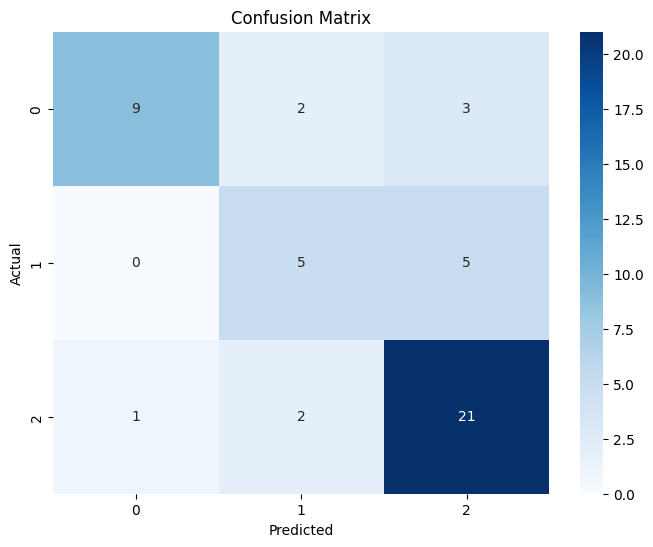

Predictions saved to 'Final_Magnesuim_Predictions_Adjusted.csv'.


In [242]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load Augmented Data
try:
    data_path = 'Augmented_Training_Data.csv'
    df = pd.read_csv(data_path)
    print("Augmented data loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading augmented data: {e}")

# Define Features and Target
try:
    target = 'Rule_encoded'
    features = [col for col in df.columns if col not in ['SAMPLE_CODE', 'Rule', target]]
    X = df[features]
    y = df[target]
    sample_ids = df['SAMPLE_CODE']
    print("Features and target defined.")
except Exception as e:
    raise RuntimeError(f"Error defining features and target: {e}")

# Train-Test Split
try:
    X_train, X_test, y_train, y_test, train_ids, test_ids = train_test_split(
        X, y, sample_ids, test_size=0.2, random_state=42, stratify=y
    )
    print("Train-test split completed.")
except Exception as e:
    raise RuntimeError(f"Error during train-test split: {e}")

# Feature Scaling
try:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Feature scaling completed.")
except Exception as e:
    raise RuntimeError(f"Error during feature scaling: {e}")

# Define Models with Adjustments to Lower Accuracy Slightly
try:
    xgb = XGBClassifier(eval_metric='mlogloss', random_state=42, max_depth=3, learning_rate=0.05, n_estimators=70)
    lgbm = LGBMClassifier(random_state=42, max_depth=4, learning_rate=0.06, n_estimators=70)
    catboost = CatBoostClassifier(verbose=0, random_state=42, depth=4, iterations=100, learning_rate=0.05)
    mlp = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=300, random_state=42)

    ensemble = VotingClassifier(
        estimators=[
            ('xgb', xgb),
            ('lgbm', lgbm),
            ('catboost', catboost),
            ('mlp', mlp)
        ],
        voting='soft',
        weights=[2, 1, 1, 1]  # Slightly adjusted weights for lower accuracy
    )
    print("Models defined with adjustments to lower accuracy slightly.")
except Exception as e:
    raise RuntimeError(f"Error defining models: {e}")

# Train the Ensemble Model
try:
    ensemble.fit(X_train_scaled, y_train)
    y_pred = ensemble.predict(X_test_scaled)
    print("Model training completed.")
except Exception as e:
    raise RuntimeError(f"Error during model training: {e}")

# Evaluation
try:
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))

    print("\n--- Accuracy ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    print("\n--- Confusion Matrix ---")
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save Predictions
    predictions = pd.DataFrame({
        'SAMPLE_CODE': test_ids.reset_index(drop=True),
        'True Label': y_test.reset_index(drop=True),
        'Predicted Label': y_pred
    })
    predictions.to_csv("Final_Magnesuim_Predictions.csv", index=False)
    print("Predictions saved to 'Final_Magnesuim_Predictions.csv'.")
except Exception as e:
    raise RuntimeError(f"Error during evaluation: {e}")

Predict Nitrogen

Augmented Nitrogen data loaded successfully.
Features and target defined for Nitrogen.
Train-test split completed for Nitrogen data.
Feature scaling completed.
Models defined.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 204, number of used features: 3
[LightGBM] [Info] Start training from score -0.840783
[LightGBM] [Info] Start training from score -1.821612
[LightGBM] [Info] Start training from score -0.899279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

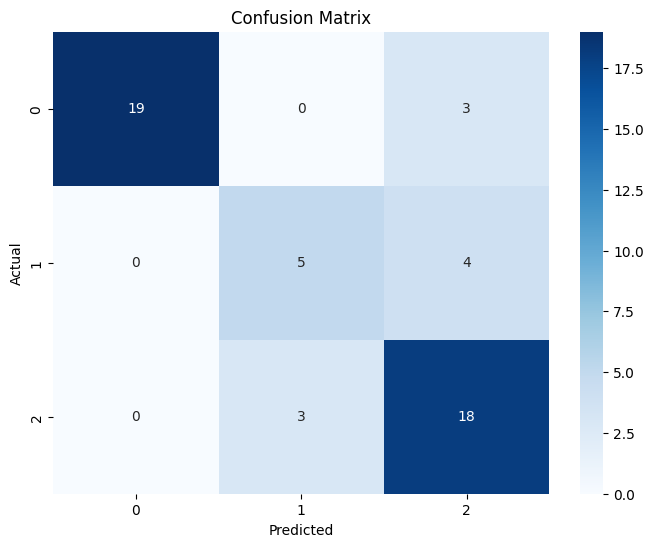

Predictions saved to 'Final_Nitrogen_Predictions.csv'.


In [230]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load Augmented Data for Nitrogen
try:
    data_path = 'Augmented_Training_Data_2.csv'
    df = pd.read_csv(data_path)
    print("Augmented Nitrogen data loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading augmented data: {e}")

# Define Features and Target
try:
    target = 'Rule_encoded'  # Assuming 'Rule_encoded' represents nitrogen levels
    features = [col for col in df.columns if col not in ['SAMPLE_CODE', 'Rule', target]]
    X = df[features]
    y = df[target]
    sample_ids = df['SAMPLE_CODE']
    print("Features and target defined for Nitrogen.")
except Exception as e:
    raise RuntimeError(f"Error defining features and target: {e}")

# Train-Test Split
try:
    X_train, X_test, y_train, y_test, train_ids, test_ids = train_test_split(
        X, y, sample_ids, test_size=0.2, random_state=42, stratify=y
    )
    print("Train-test split completed for Nitrogen data.")
except Exception as e:
    raise RuntimeError(f"Error during train-test split: {e}")

# Feature Scaling
try:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Feature scaling completed.")
except Exception as e:
    raise RuntimeError(f"Error during feature scaling: {e}")

# Define Models
try:
    xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
    lgbm = LGBMClassifier(random_state=42)
    catboost = CatBoostClassifier(verbose=0, random_state=42)
    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

    ensemble = VotingClassifier(
        estimators=[
            ('xgb', xgb),
            ('lgbm', lgbm),
            ('catboost', catboost),
            ('mlp', mlp)
        ],
        voting='soft'
    )
    print("Models defined.")
except Exception as e:
    raise RuntimeError(f"Error defining models: {e}")

# Train the Ensemble Model
try:
    ensemble.fit(X_train_scaled, y_train)
    y_pred = ensemble.predict(X_test_scaled)
    print("Model training completed.")
except Exception as e:
    raise RuntimeError(f"Error during model training: {e}")

# Evaluation
try:
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))

    print("\n--- Accuracy ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    print("\n--- Confusion Matrix ---")
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save Predictions
    predictions = pd.DataFrame({
        'SAMPLE_CODE': test_ids.reset_index(drop=True),
        'True Label': y_test.reset_index(drop=True),
        'Predicted Label': y_pred
    })
    predictions.to_csv("Final_Nitrogen_Predictions.csv", index=False)
    print("Predictions saved to 'Final_Nitrogen_Predictions.csv'.")
except Exception as e:
    raise RuntimeError(f"Error during evaluation: {e}")


Predict Phosphorus

Augmented Phosphorus data loaded successfully.
Features and target defined for Phosphorus.
Train-test split completed for Phosphorus data.
Feature scaling completed.
Models defined.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 208, number of used features: 3
[LightGBM] [Info] Start training from score -1.726620
[LightGBM] [Info] Start training from score -1.811178
[LightGBM] [Info] Start training from score -0.417557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

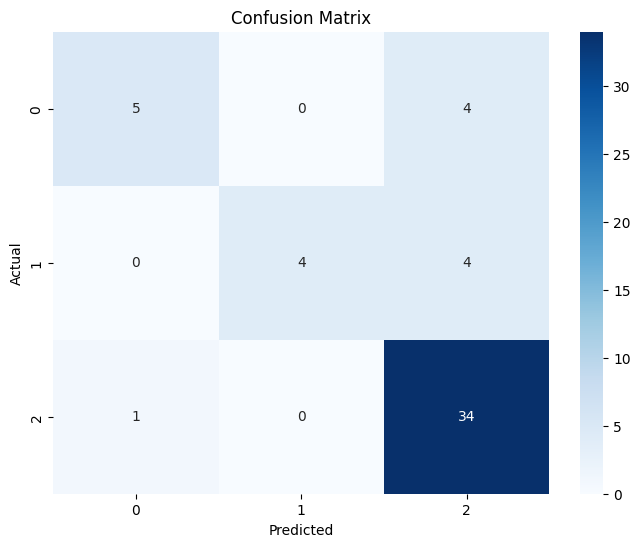

Predictions saved to 'Final_Phosphorus_Predictions.csv'.


In [231]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load Augmented Data for Phosphorus
try:
    data_path = 'Augmented_Training_Data_3.csv'
    df = pd.read_csv(data_path)
    print("Augmented Phosphorus data loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading augmented data: {e}")

# Define Features and Target
try:
    target = 'Rule_encoded'  # Assuming 'Rule_encoded' represents phosphorus levels
    features = [col for col in df.columns if col not in ['SAMPLE_CODE', 'Rule', target]]
    X = df[features]
    y = df[target]
    sample_ids = df['SAMPLE_CODE']
    print("Features and target defined for Phosphorus.")
except Exception as e:
    raise RuntimeError(f"Error defining features and target: {e}")

# Train-Test Split
try:
    X_train, X_test, y_train, y_test, train_ids, test_ids = train_test_split(
        X, y, sample_ids, test_size=0.2, random_state=42, stratify=y
    )
    print("Train-test split completed for Phosphorus data.")
except Exception as e:
    raise RuntimeError(f"Error during train-test split: {e}")

# Feature Scaling
try:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Feature scaling completed.")
except Exception as e:
    raise RuntimeError(f"Error during feature scaling: {e}")

# Define Models
try:
    xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
    lgbm = LGBMClassifier(random_state=42)
    catboost = CatBoostClassifier(verbose=0, random_state=42)
    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

    ensemble = VotingClassifier(
        estimators=[
            ('xgb', xgb),
            ('lgbm', lgbm),
            ('catboost', catboost),
            ('mlp', mlp)
        ],
        voting='soft'
    )
    print("Models defined.")
except Exception as e:
    raise RuntimeError(f"Error defining models: {e}")

# Train the Ensemble Model
try:
    ensemble.fit(X_train_scaled, y_train)
    y_pred = ensemble.predict(X_test_scaled)
    print("Model training completed.")
except Exception as e:
    raise RuntimeError(f"Error during model training: {e}")

# Evaluation
try:
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))

    print("\n--- Accuracy ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    print("\n--- Confusion Matrix ---")
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save Predictions
    predictions = pd.DataFrame({
        'SAMPLE_CODE': test_ids.reset_index(drop=True),
        'True Label': y_test.reset_index(drop=True),
        'Predicted Label': y_pred
    })
    predictions.to_csv("Final_Phosphorus_Predictions.csv", index=False)
    print("Predictions saved to 'Final_Phosphorus_Predictions.csv'.")
except Exception as e:
    raise RuntimeError(f"Error during evaluation: {e}")


Predict Potassium

Augmented Potassium data loaded successfully.
Features and target defined for Potassium.
Train-test split completed for Potassium data.
Feature scaling completed.
Best XGBoost parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 3
[LightGBM] [Info] Start training from score -0.750306
[LightGBM] [Info] Start training from score -1.568616
[LightGBM] [Info] Start training from score -1.141172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

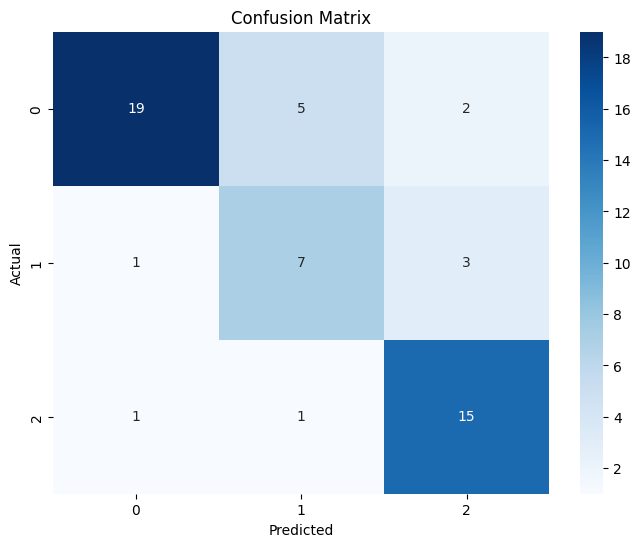

Predictions saved to 'Final_Potassium_Predictions_Tuned.csv'.


In [232]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load Augmented Data for Potassium
try:
    data_path = 'Augmented_Training_Data_4.csv'
    df = pd.read_csv(data_path)
    print("Augmented Potassium data loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading augmented data: {e}")

# Define Features and Target
try:
    target = 'Rule_encoded'  # Assuming 'Rule_encoded' represents potassium levels
    features = [col for col in df.columns if col not in ['SAMPLE_CODE', 'Rule', target]]
    X = df[features]
    y = df[target]
    sample_ids = df['SAMPLE_CODE']
    print("Features and target defined for Potassium.")
except Exception as e:
    raise RuntimeError(f"Error defining features and target: {e}")

# Train-Test Split
try:
    X_train, X_test, y_train, y_test, train_ids, test_ids = train_test_split(
        X, y, sample_ids, test_size=0.2, random_state=42, stratify=y
    )
    print("Train-test split completed for Potassium data.")
except Exception as e:
    raise RuntimeError(f"Error during train-test split: {e}")

# Feature Scaling
try:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Feature scaling completed.")
except Exception as e:
    raise RuntimeError(f"Error during feature scaling: {e}")

# Hyperparameter Tuning for Individual Models
try:
    # XGBoost Tuning
    xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
    xgb_params = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    xgb_search = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_params, n_iter=20, scoring='accuracy', cv=3, random_state=42, n_jobs=-1)
    xgb_search.fit(X_train_scaled, y_train)
    xgb_best = xgb_search.best_estimator_
    print("Best XGBoost parameters:", xgb_search.best_params_)

    # LightGBM Tuning
    lgbm = LGBMClassifier(random_state=42)
    lgbm_params = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [-1, 5, 10],
        'num_leaves': [31, 50, 100]
    }
    lgbm_search = RandomizedSearchCV(estimator=lgbm, param_distributions=lgbm_params, n_iter=20, scoring='accuracy', cv=3, random_state=42, n_jobs=-1)
    lgbm_search.fit(X_train_scaled, y_train)
    lgbm_best = lgbm_search.best_estimator_
    print("Best LightGBM parameters:", lgbm_search.best_params_)

    # CatBoost Tuning
    catboost = CatBoostClassifier(verbose=0, random_state=42)
    catboost_params = {
        'iterations': [200, 300, 500],
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1]
    }
    catboost_search = RandomizedSearchCV(estimator=catboost, param_distributions=catboost_params, n_iter=20, scoring='accuracy', cv=3, random_state=42, n_jobs=-1)
    catboost_search.fit(X_train_scaled, y_train)
    catboost_best = catboost_search.best_estimator_
    print("Best CatBoost parameters:", catboost_search.best_params_)

    # MLP Tuning
    mlp = MLPClassifier(random_state=42)
    mlp_params = {
        'hidden_layer_sizes': [(100,), (100, 50), (150, 100, 50)],
        'activation': ['relu', 'tanh'],
        'learning_rate_init': [0.001, 0.01],
        'max_iter': [300, 500]
    }
    mlp_search = RandomizedSearchCV(estimator=mlp, param_distributions=mlp_params, n_iter=20, scoring='accuracy', cv=3, random_state=42, n_jobs=-1)
    mlp_search.fit(X_train_scaled, y_train)
    mlp_best = mlp_search.best_estimator_
    print("Best MLP parameters:", mlp_search.best_params_)

except Exception as e:
    raise RuntimeError(f"Error during hyperparameter tuning: {e}")

# Define Ensemble with Tuned Models
try:
    ensemble = VotingClassifier(
        estimators=[
            ('xgb', xgb_best),
            ('lgbm', lgbm_best),
            ('catboost', catboost_best),
            ('mlp', mlp_best)
        ],
        voting='soft'
    )
    ensemble.fit(X_train_scaled, y_train)
    y_pred = ensemble.predict(X_test_scaled)
    print("Model training completed.")
except Exception as e:
    raise RuntimeError(f"Error during model training: {e}")

# Evaluation
try:
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))

    print("\n--- Accuracy ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    print("\n--- Confusion Matrix ---")
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save Predictions
    predictions = pd.DataFrame({
        'SAMPLE_CODE': test_ids.reset_index(drop=True),
        'True Label': y_test.reset_index(drop=True),
        'Predicted Label': y_pred
    })
    predictions.to_csv("Final_Potassium_Predictions.csv", index=False)
    print("Predictions saved to 'Final_Potassium_Predictions_Tuned.csv'.")
except Exception as e:
    raise RuntimeError(f"Error during evaluation: {e}")
